# A notebook to carry out calculations

In [10]:
import sympy as sym
import scipy as sp
sym.init_printing()

assert sym.__version__ == "1.0"
assert sp.__version__ == "0.19.0"

Defining all our variables (with assumption that they are positive).

In [129]:
r, s, x, theta_r, alpha, H, R_1, R_2, beta, gamma, F = sym.symbols("r, s, x, theta_r, alpha, H, R_1, R_2, beta, gamma, F", positive=True)

Defining the functions:

In [151]:
def theta(r, s, theta_r=theta_r):
    """
    Return the quantity of horn gained:
    
    Parameters
    ----------
    
    s: float between 0 and 1 - the proportion of poachers acting selectively
    r: float between 0 and 1 - the proportion of horns devalued
    theta_r: float between 0 and 1 - the value of dehorned horn
    """
    return s * (1 - r) + (1 - s) * ((theta_r - 1) * r + 1)

In [152]:
theta(r, s)

In [153]:
def phi(r, s, R_1=R_1, R_2=R_2):
    """
    Returns the risk associated with poaching:
    
    Parameters
    ----------
    
    R_1 < R_2 : constants associated with poaching
    """
    return R_1 * s + R_2 * (1 - s)

In [154]:
phi(r, s)

In [155]:
def psi(r, s):
    """
    Returns the cost associated with finding a rhino
    """
    return 1 - r * s

In [156]:
psi(r, s)

In [157]:
def utility(s, x, H=H, r=r, theta_r=theta_r, R_1=R_1, R_2=R_2, F=F, alpha=alpha, beta=beta, gamma=gamma):
    """
    The total utility for a strategy 
    sigma=(s, 1-s) in a population chi=(x, 1-x)
    """
    selective_utility = theta(r, 1) * H * theta(r, x) ** (- alpha)
    selective_utility += - phi(r, 1) * (1 - r) ** (- beta)
    selective_utility += - psi(r, 1) * F * psi(r, x) ** (- gamma)
    
    indiscriminate_utility = theta(r, 0) * H * theta(r, x) ** (- alpha)
    indiscriminate_utility += - phi(r, 0) * (1 - r) ** (- beta)
    indiscriminate_utility += - psi(r, 0) * F * psi(r, x) ** (- gamma)

    return s * selective_utility + (1 - s) * indiscriminate_utility

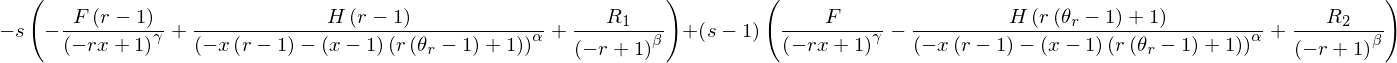

In [137]:
utility(s, x).simplify()

Condition for $s=1$ to be stable:

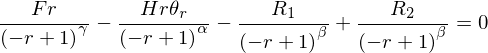

In [161]:
expr = utility(1, 1) - utility(0, 1)
stable_selective_condition = sym.Eq(expr.expand(), 0)
stable_selective_condition

Condition for $s=0$ to be stable:

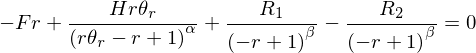

In [164]:
expr = utility(0, 0) - utility(1, 0)
stable_indiscrimate_condition = sym.Eq(expr.expand(), 0)
stable_indiscrimate_condition

Limit behaviour as $r\to 1$:

In [165]:
sym.limit(expr, r, 1)

Condition for $1>s^*>0$ to be stable:

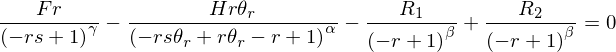

In [166]:
expr = utility(1, s) - utility(0, s)
stable_mixed_condition = sym.Eq(expr.simplify(), 0)
stable_mixed_condition

In preparation for numerical solution: let's see what the derivaties of the lhs of that are:

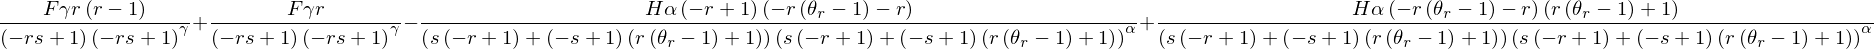

In [167]:
sym.diff(expr, s)

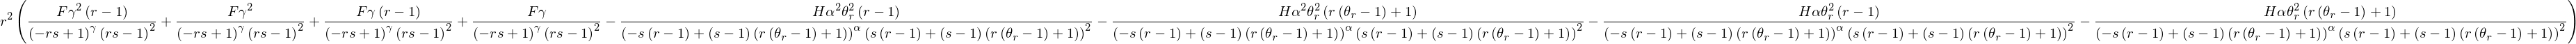

In [168]:
sym.diff(expr, s, 2)